<a href="https://colab.research.google.com/github/ucaokylong/U_net_for_segmentation_and_translation/blob/main/Segmentation_PixelShuffle_SkipConnection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# depth_to_space

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTT0VLL/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTT0VLL/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

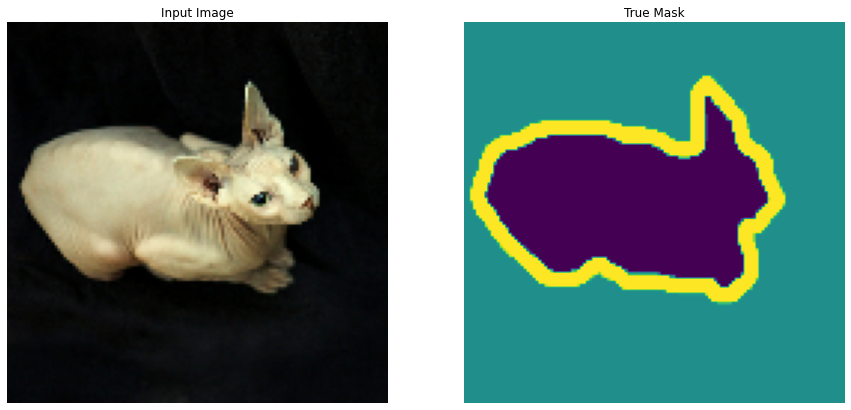

In [ ]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [ ]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])    
x = inputs  

r = 2

# block 1
x = tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
pre1 = x

# block 2
x = tf.keras.layers.Conv2D(128, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
pre2 = x

# block 3
x = tf.keras.layers.Conv2D(256, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
pre3 = x

# block 4
x = tf.keras.layers.Conv2D(512, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
pre4 = x

# block 5
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# upsampling
x = tf.keras.layers.Conv2D(512*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, pre4])

# upsampling
x = tf.keras.layers.Conv2D(256*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, pre3])

# upsampling
x = tf.keras.layers.Conv2D(128*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, pre2])

# upsampling
x = tf.keras.layers.Conv2D(64*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, pre1])

# upsampling
x = tf.keras.layers.Conv2D(32*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.Conv2D(3, 3, padding='same')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 add_3 (Add)                    (None, 64, 64, 64)   0           ['batch_normalization_8[0][0]',  
                                                                  'max_pooling2d[0][0]']          
                                                                                                  
 conv2d_9 (Conv2D)              (None, 64, 64, 128)  73856       ['add_3[0][0]']                  
                                                                                                  
 tf.nn.depth_to_space_4 (TFOpLa  (None, 128, 128, 32  0          ['conv2d_9[0][0]']               
 mbda)                          )                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 3)  867         ['tf.nn.depth_to_space_4[0][0]'] 
                                                                                                  
Total para

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-15 10:29:07.006581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-15 10:29:07.468916: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:29:07.469315: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:29:07.469329: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-15 10:29:07.469672: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:29:07.469705: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

  4/920 [..............................] - ETA: 22s - loss: 1.4186 - accuracy: 0.3497  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0100s vs `on_train_batch_end` time: 0.0117s). Check your callbacks.


918/920 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.7075

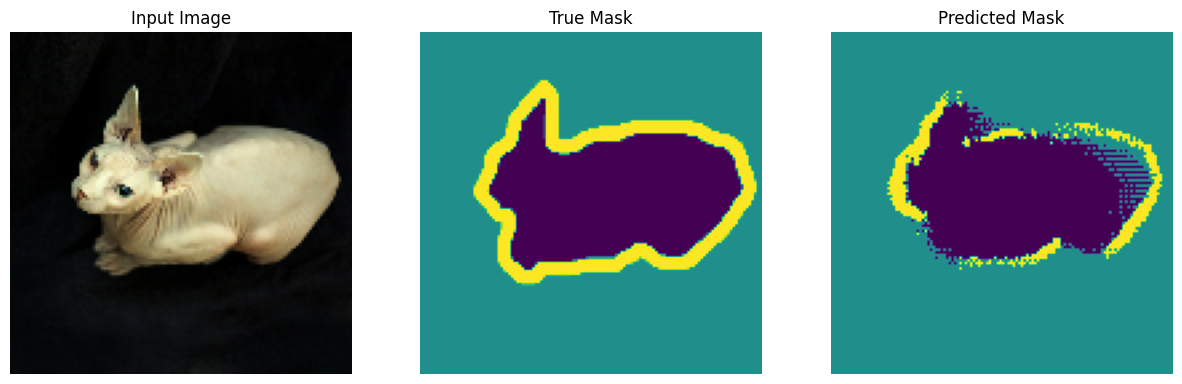


Sample Prediction after epoch 1

920/920 [==============================] - 27s 26ms/step - loss: 0.6835 - accuracy: 0.7075 - val_loss: 0.5987 - val_accuracy: 0.7515
Epoch 2/20
920/920 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7641

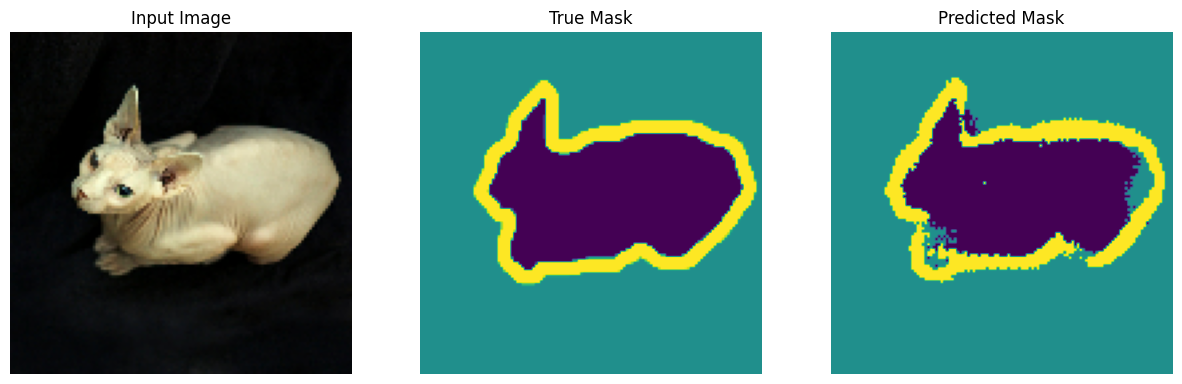


Sample Prediction after epoch 2

920/920 [==============================] - 23s 25ms/step - loss: 0.5672 - accuracy: 0.7641 - val_loss: 0.5990 - val_accuracy: 0.7552
Epoch 3/20
919/920 [============================>.] - ETA: 0s - loss: 0.5111 - accuracy: 0.7906

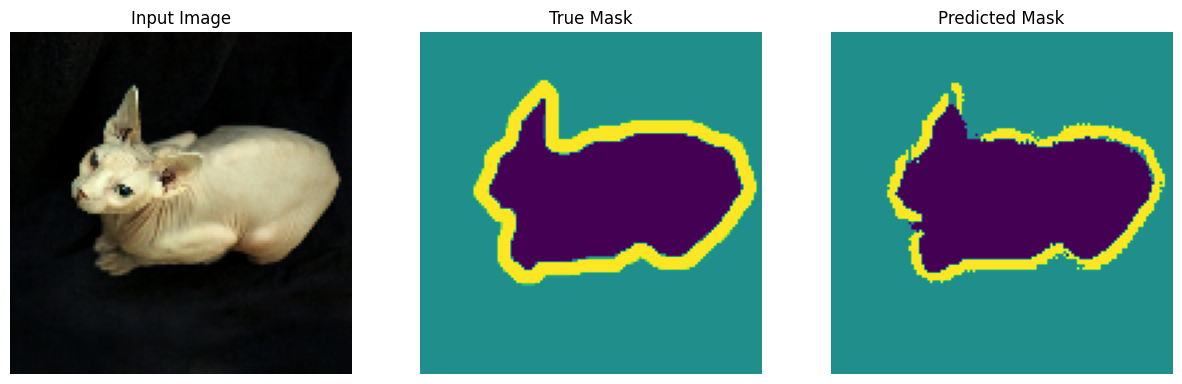


Sample Prediction after epoch 3

920/920 [==============================] - 23s 25ms/step - loss: 0.5110 - accuracy: 0.7906 - val_loss: 0.5101 - val_accuracy: 0.7929
Epoch 4/20
918/920 [============================>.] - ETA: 0s - loss: 0.4727 - accuracy: 0.8062

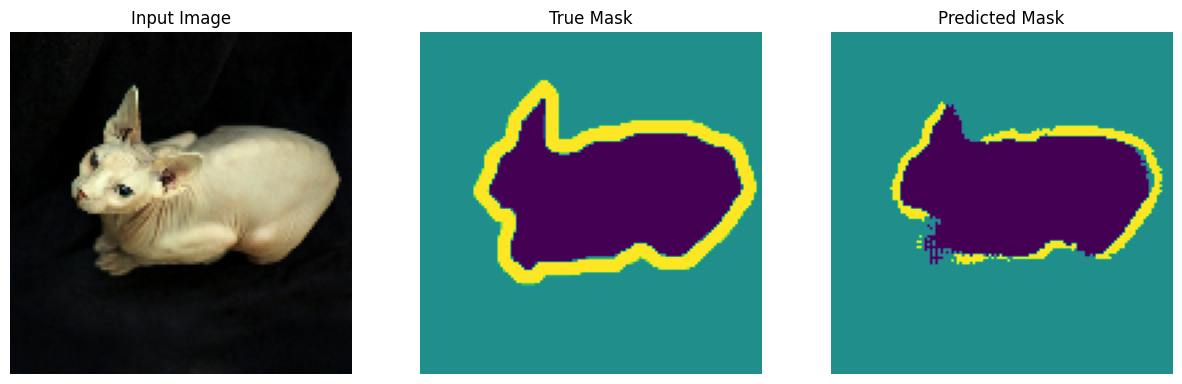


Sample Prediction after epoch 4

920/920 [==============================] - 23s 25ms/step - loss: 0.4726 - accuracy: 0.8062 - val_loss: 0.5236 - val_accuracy: 0.7787
Epoch 5/20
920/920 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8174

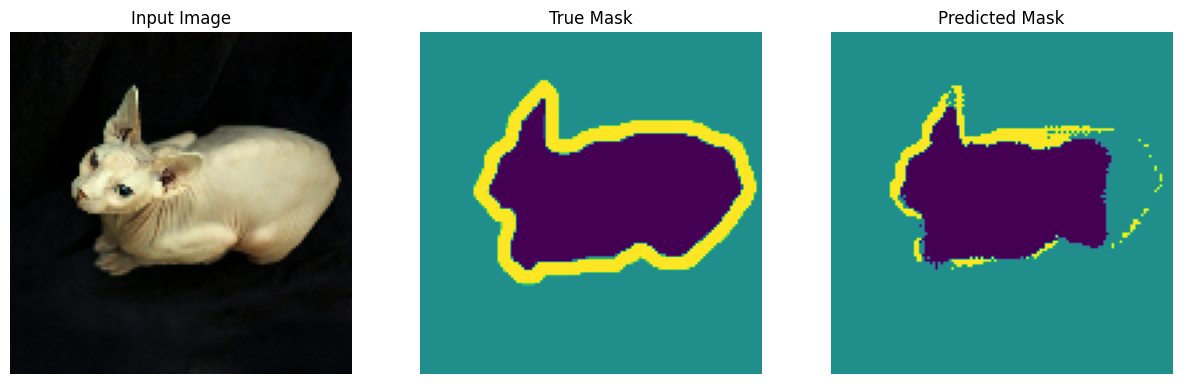


Sample Prediction after epoch 5

920/920 [==============================] - 23s 25ms/step - loss: 0.4459 - accuracy: 0.8174 - val_loss: 0.5389 - val_accuracy: 0.7705
Epoch 6/20
918/920 [============================>.] - ETA: 0s - loss: 0.4172 - accuracy: 0.8292

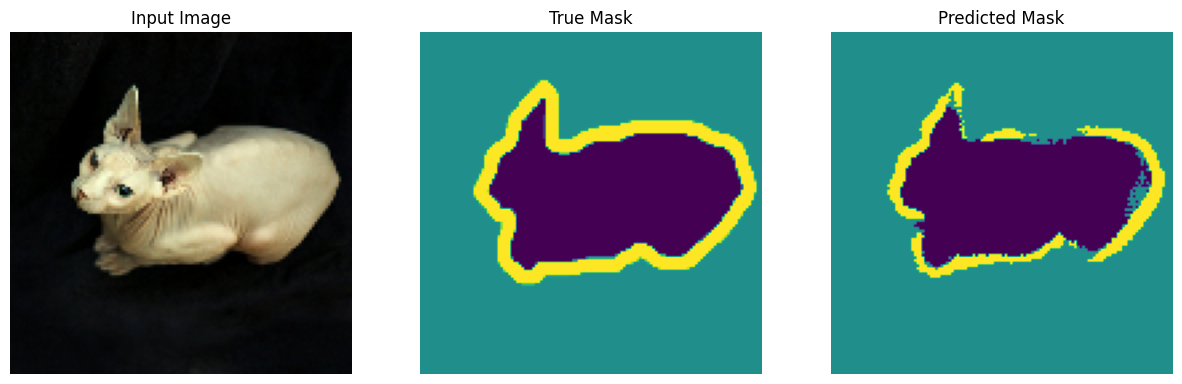


Sample Prediction after epoch 6

920/920 [==============================] - 23s 25ms/step - loss: 0.4173 - accuracy: 0.8292 - val_loss: 0.4564 - val_accuracy: 0.8135
Epoch 7/20
918/920 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8390

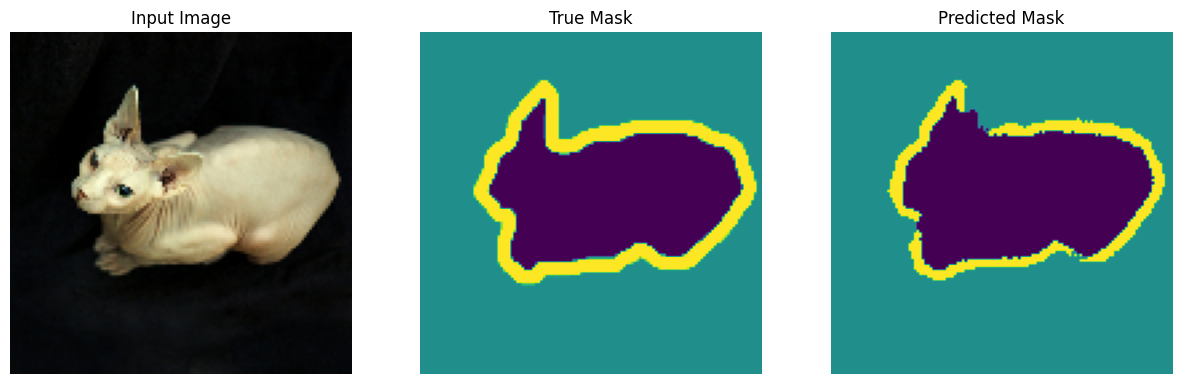


Sample Prediction after epoch 7

920/920 [==============================] - 23s 25ms/step - loss: 0.3930 - accuracy: 0.8391 - val_loss: 0.4521 - val_accuracy: 0.8183
Epoch 8/20
918/920 [============================>.] - ETA: 0s - loss: 0.3592 - accuracy: 0.8526

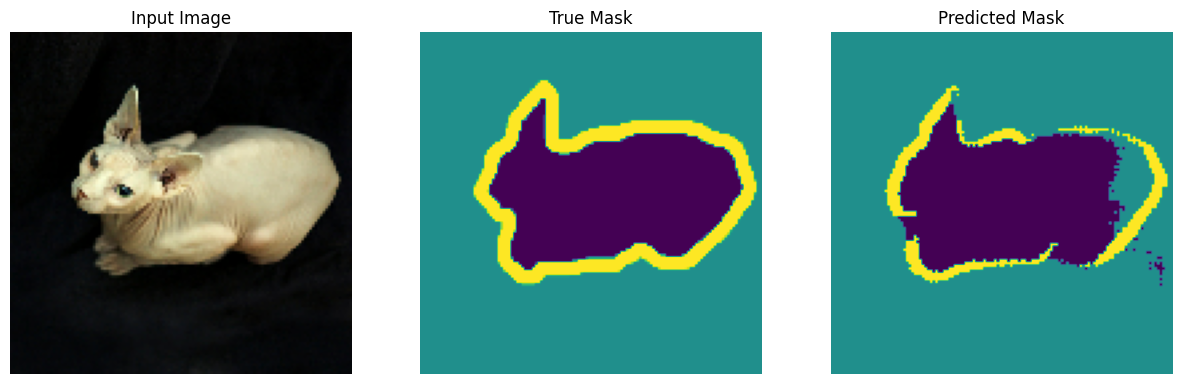


Sample Prediction after epoch 8

920/920 [==============================] - 23s 25ms/step - loss: 0.3590 - accuracy: 0.8527 - val_loss: 0.4258 - val_accuracy: 0.8266
Epoch 9/20
918/920 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8646

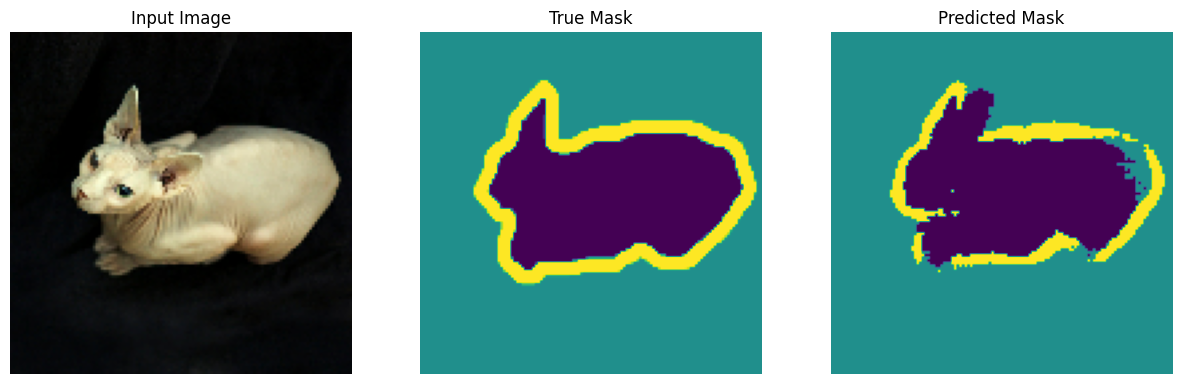


Sample Prediction after epoch 9

920/920 [==============================] - 23s 25ms/step - loss: 0.3273 - accuracy: 0.8646 - val_loss: 0.5938 - val_accuracy: 0.7925
Epoch 10/20
918/920 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8757

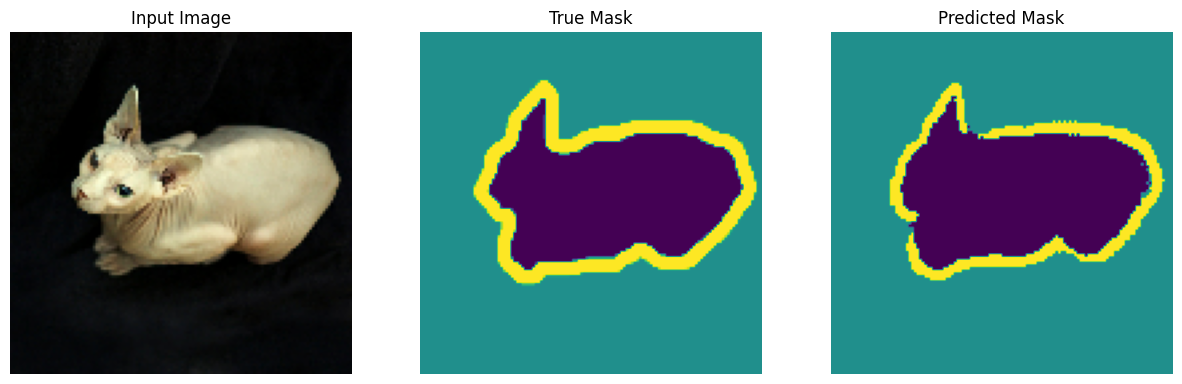


Sample Prediction after epoch 10

920/920 [==============================] - 23s 25ms/step - loss: 0.2983 - accuracy: 0.8758 - val_loss: 0.4416 - val_accuracy: 0.8301
Epoch 11/20
918/920 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8831

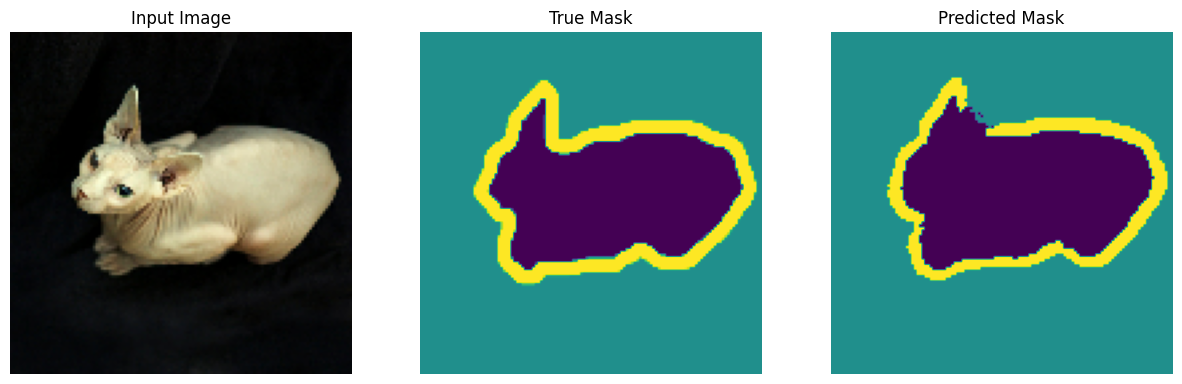


Sample Prediction after epoch 11

920/920 [==============================] - 23s 25ms/step - loss: 0.2787 - accuracy: 0.8831 - val_loss: 0.4260 - val_accuracy: 0.8378
Epoch 12/20
918/920 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8931

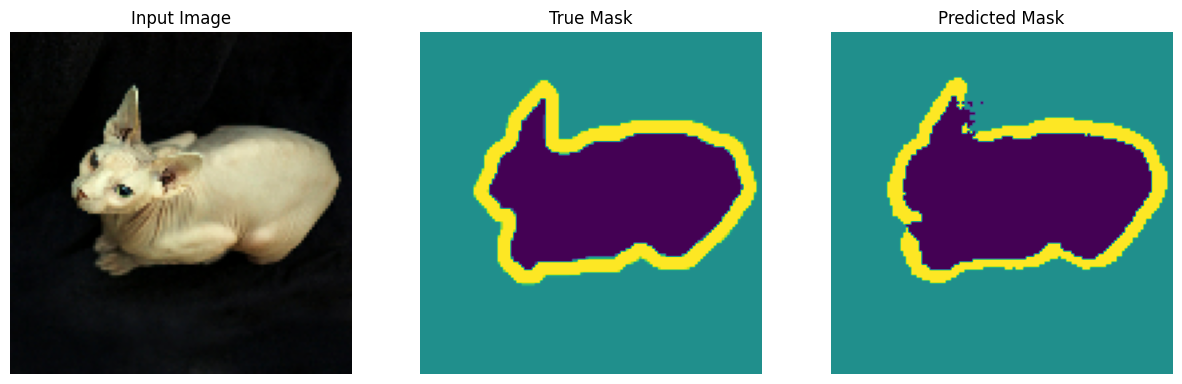


Sample Prediction after epoch 12

920/920 [==============================] - 23s 25ms/step - loss: 0.2516 - accuracy: 0.8931 - val_loss: 0.4273 - val_accuracy: 0.8448
Epoch 13/20
920/920 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9006

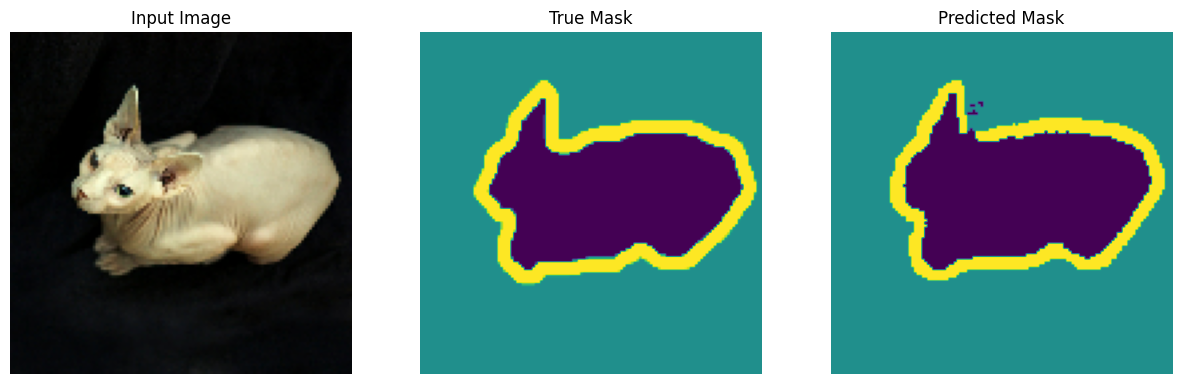


Sample Prediction after epoch 13

920/920 [==============================] - 23s 25ms/step - loss: 0.2319 - accuracy: 0.9006 - val_loss: 0.4631 - val_accuracy: 0.8310
Epoch 14/20
918/920 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9055

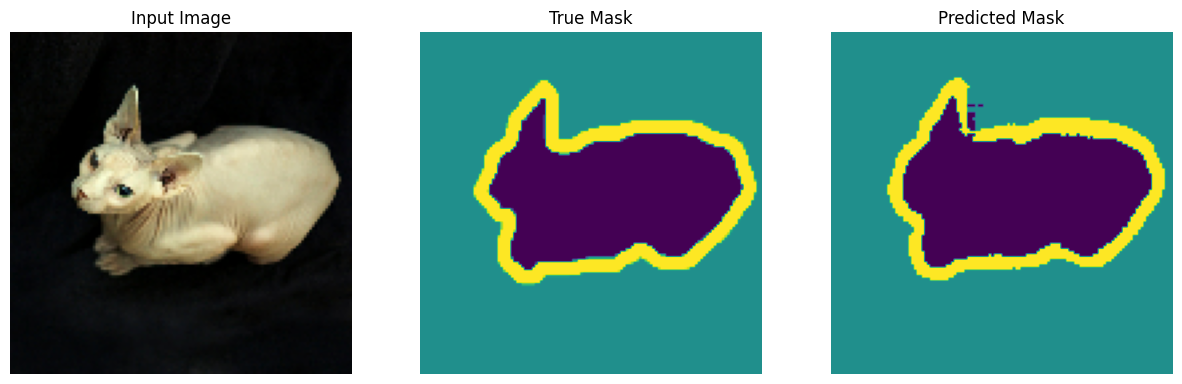


Sample Prediction after epoch 14

920/920 [==============================] - 23s 25ms/step - loss: 0.2181 - accuracy: 0.9056 - val_loss: 0.4701 - val_accuracy: 0.8385
Epoch 15/20
918/920 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9105

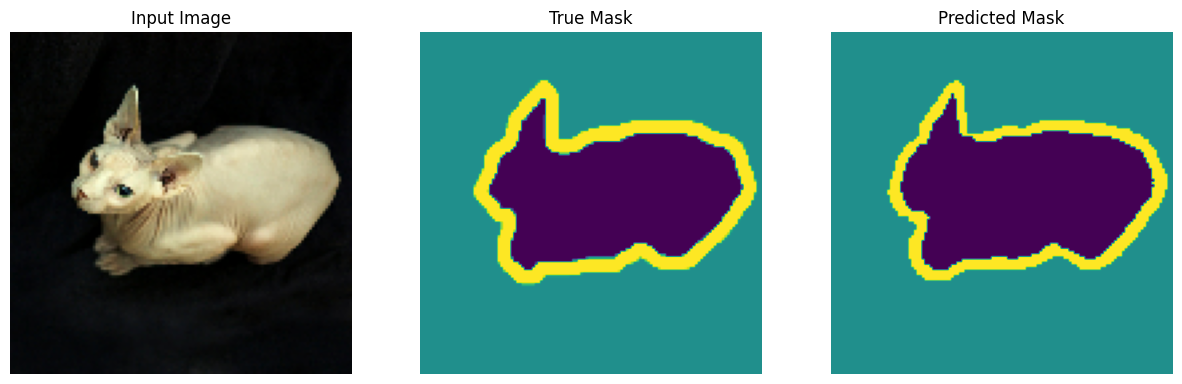


Sample Prediction after epoch 15

920/920 [==============================] - 24s 26ms/step - loss: 0.2049 - accuracy: 0.9106 - val_loss: 0.4660 - val_accuracy: 0.8438
Epoch 16/20
919/920 [============================>.] - ETA: 0s - loss: 0.1920 - accuracy: 0.9154

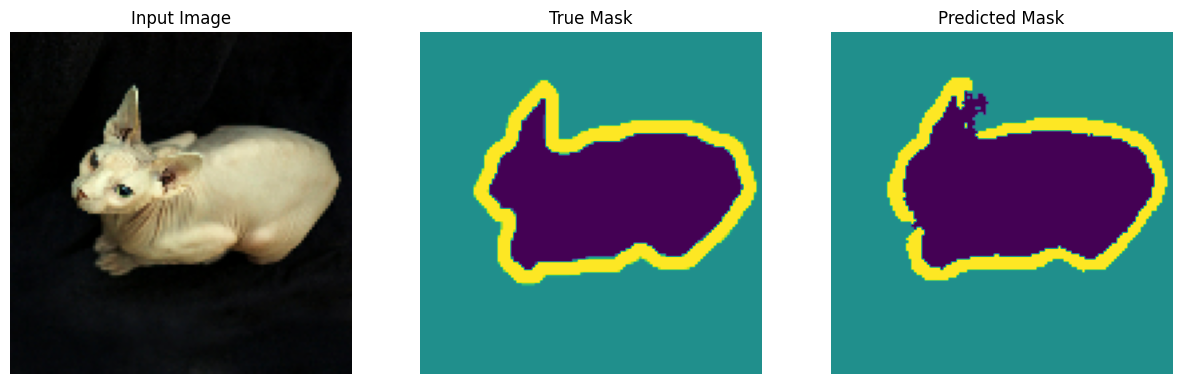


Sample Prediction after epoch 16

920/920 [==============================] - 23s 25ms/step - loss: 0.1919 - accuracy: 0.9154 - val_loss: 0.4767 - val_accuracy: 0.8371
Epoch 17/20
919/920 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9195

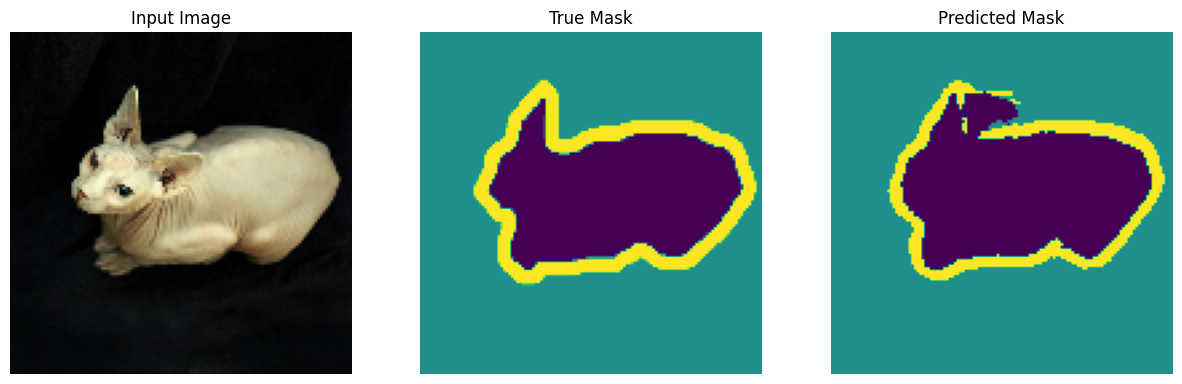


Sample Prediction after epoch 17

920/920 [==============================] - 23s 25ms/step - loss: 0.1814 - accuracy: 0.9195 - val_loss: 0.4720 - val_accuracy: 0.8420
Epoch 18/20
919/920 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9244

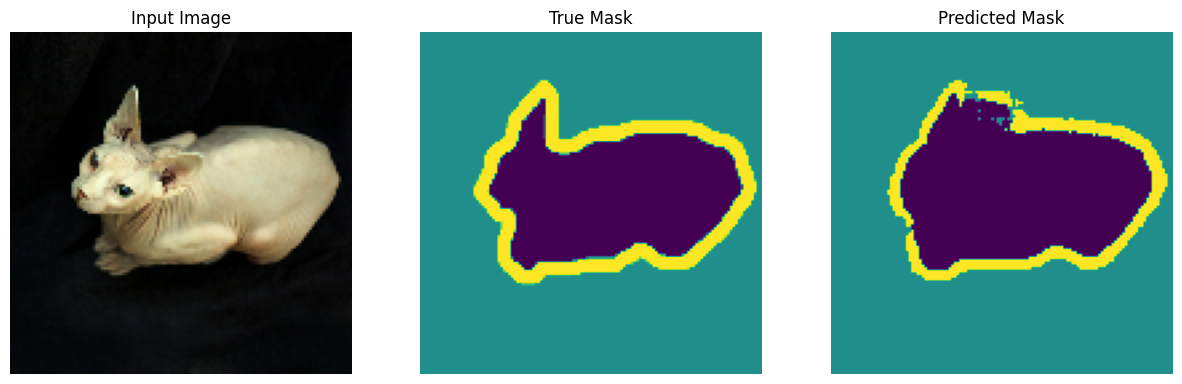


Sample Prediction after epoch 18

920/920 [==============================] - 23s 25ms/step - loss: 0.1691 - accuracy: 0.9244 - val_loss: 0.5025 - val_accuracy: 0.8455
Epoch 19/20
919/920 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9268

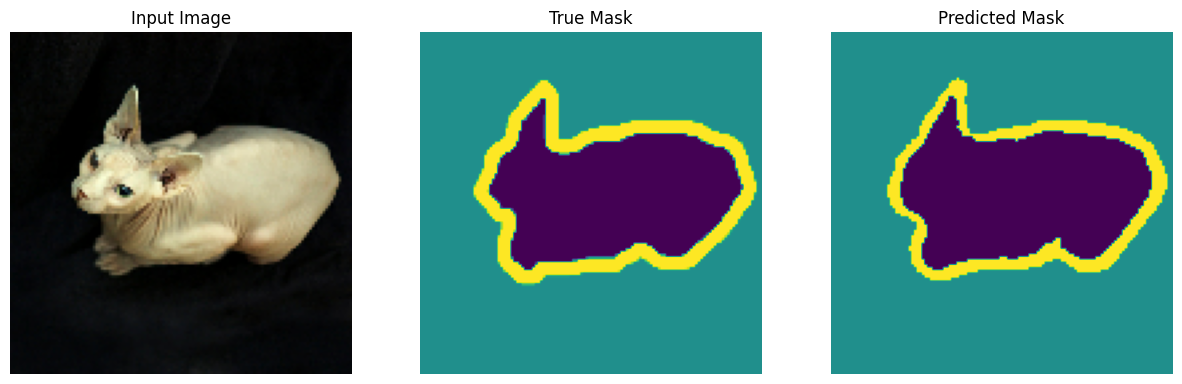


Sample Prediction after epoch 19

920/920 [==============================] - 23s 25ms/step - loss: 0.1632 - accuracy: 0.9267 - val_loss: 0.4755 - val_accuracy: 0.8456
Epoch 20/20
919/920 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9314

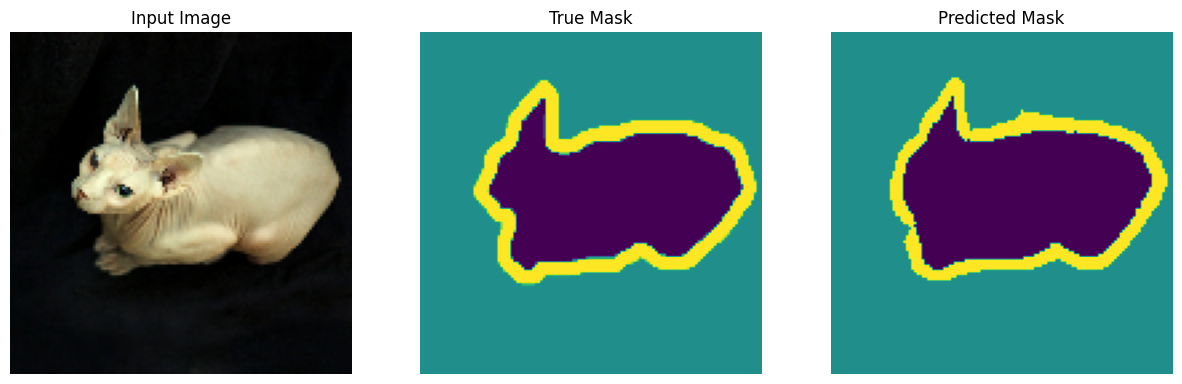


Sample Prediction after epoch 20

920/920 [==============================] - 23s 25ms/step - loss: 0.1515 - accuracy: 0.9314 - val_loss: 0.4780 - val_accuracy: 0.8501


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

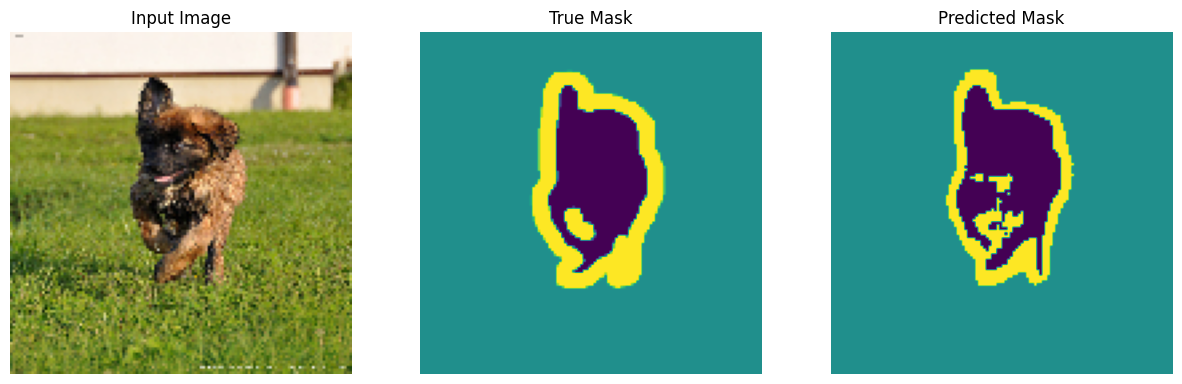

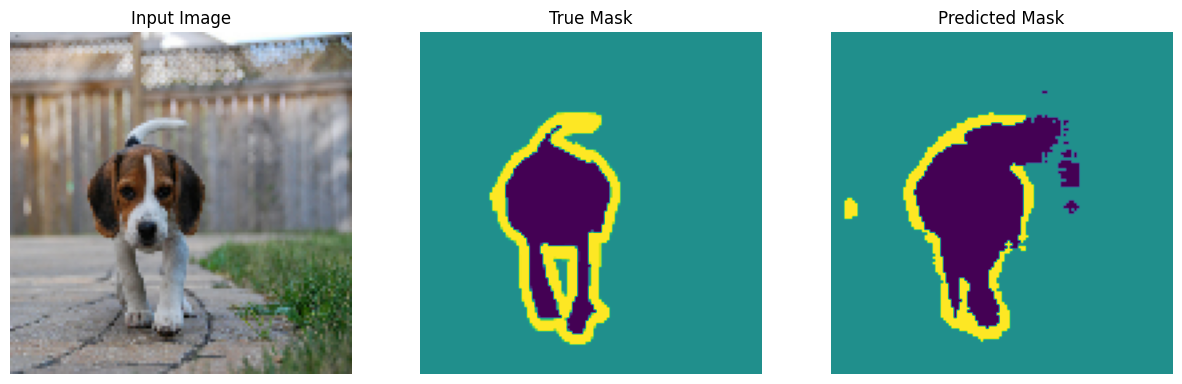

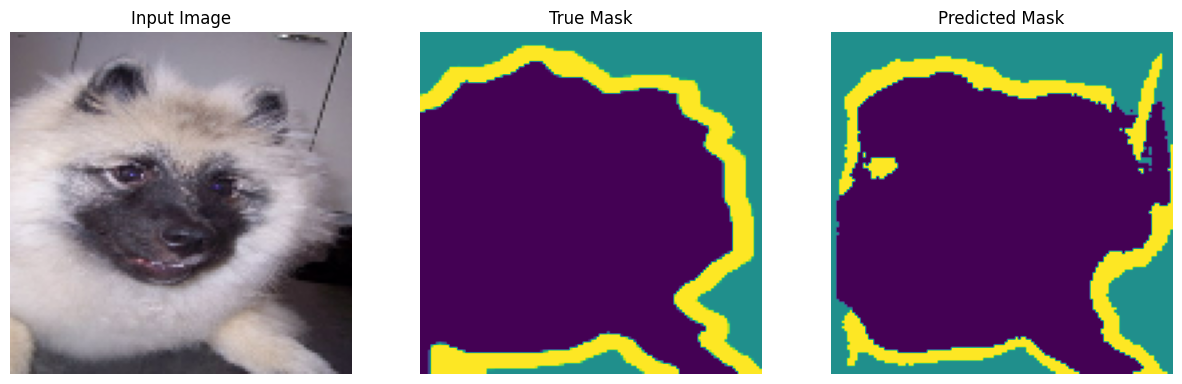

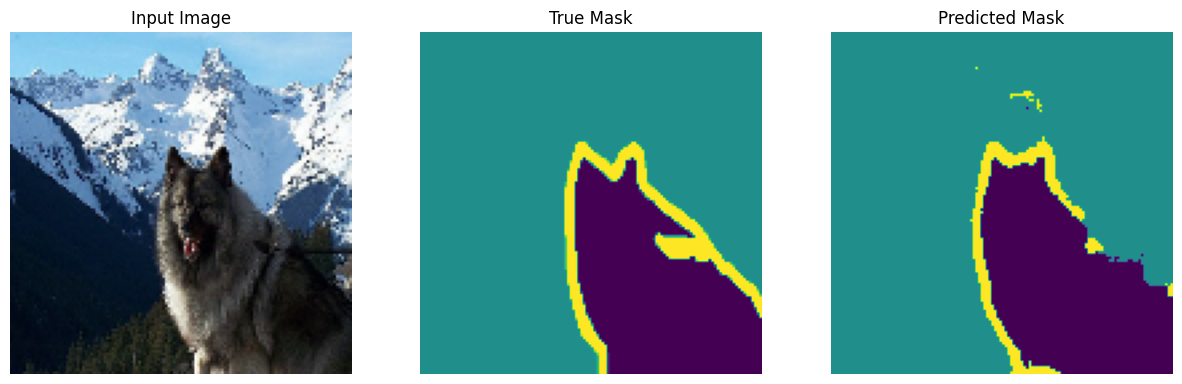

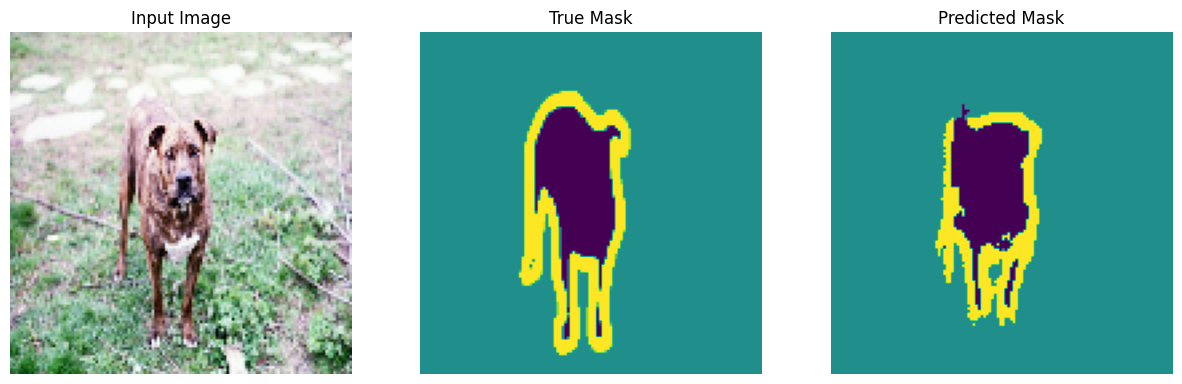

In [ ]:
show_predictions(test_dataset, 5)